# 1. Import required libraries

In [1]:
%%capture
!pip install timm
!pip install randaugment

In [2]:
import os
import PIL
import time
import timm
import math
import copy
import torch
import torchvision
import itertools
import numpy as np
%matplotlib inline
import torch.nn as nn
from PIL import Image
from copy import deepcopy
import torch.optim as optim
import matplotlib.pyplot as plt
from timm.models.layers.activations import *
from collections import OrderedDict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from timm.loss import LabelSmoothingCrossEntropy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from randaugment import RandAugment, ImageNetPolicy, Cutout
from tqdm import tqdm

# 2. Data Preparation

In [3]:
# Hyperparameters
batch_size = 32
num_epochs = 30

In [4]:
root_dir = '/kaggle/input/chest-xray-classification'
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        Cutout(size=16),
        RandAugment(),
        ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [5]:
image_datasets = {x : datasets.ImageFolder(os.path.join(root_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
data_loader = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size if x!='test' else 2, shuffle=True, num_workers=2, pin_memory=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [6]:
print(dataset_sizes)
print(class_names)

{'train': 17813, 'val': 2227, 'test': 2229}
['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']


# 3. Model

In [7]:
model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
model.head

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


Linear(in_features=1024, out_features=1000, bias=True)

In [8]:
from collections import OrderedDict
head = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 512)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(512, 256)),
    ('relu2', nn.ReLU()),
    ('fc3', nn.Linear(256, 5))
]))
model.head = head
model = model.to(device)

for params in model.parameters():
    params.requires_grad = True
    
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_params(model))

87400637


# 4. Training

In [9]:
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs , path='model.pth'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.
    
    for epoch in range(num_epochs):
        since_e = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_correct = 0
            
            for i, (inputs, labels) in tqdm(enumerate(data_loader[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                if i%1000==999:
                    print(f"[{epoch+1}, {i} loss: {running_loss/(i*inputs.size(0)):.4f}]")
                
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item()*inputs.size(0)
                running_correct += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_correct / dataset_sizes[phase]
            print('{} loss: {:.4f} acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                scheduler.step()
            if phase == 'val' and epoch_acc > best_acc:
                print(f'New acc: {epoch_acc:.4f}, previous acc: {best_acc:.4f}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path)
        time_e = time.time() - since_e
        print(f'Training epoch {epoch+1} complete in: {time_e//60:.0f}m {time_e%60:.0f}s')
    time_elapsed = time.time()-since
    print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))
    
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/30


557it [07:03,  1.32it/s]

train loss: 1.0622 acc: 0.6486



70it [00:29,  2.41it/s]


val loss: 0.7734 acc: 0.8154
New acc: 0.8154, previous acc: 0.0000
Training epoch 1 complete in: 7m 33s
Epoch 2/30


557it [06:37,  1.40it/s]

train loss: 0.8870 acc: 0.7429



70it [00:24,  2.83it/s]


val loss: 0.6801 acc: 0.8532
New acc: 0.8532, previous acc: 0.8154
Training epoch 2 complete in: 7m 4s
Epoch 3/30


557it [06:39,  1.39it/s]

train loss: 0.8427 acc: 0.7697



70it [00:25,  2.76it/s]

val loss: 0.7225 acc: 0.8289
Training epoch 3 complete in: 7m 5s
Epoch 4/30



557it [06:39,  1.39it/s]

train loss: 0.8017 acc: 0.7895



70it [00:25,  2.71it/s]


val loss: 0.6659 acc: 0.8644
New acc: 0.8644, previous acc: 0.8532
Training epoch 4 complete in: 7m 7s
Epoch 5/30


557it [06:39,  1.40it/s]

train loss: 0.7669 acc: 0.8063



70it [00:25,  2.75it/s]


val loss: 0.6098 acc: 0.8945
New acc: 0.8945, previous acc: 0.8644
Training epoch 5 complete in: 7m 6s
Epoch 6/30


557it [06:43,  1.38it/s]

train loss: 0.7557 acc: 0.8100



70it [00:25,  2.75it/s]

val loss: 0.6479 acc: 0.8729
Training epoch 6 complete in: 7m 9s
Epoch 7/30



557it [06:40,  1.39it/s]

train loss: 0.7254 acc: 0.8284



70it [00:26,  2.68it/s]

val loss: 0.6310 acc: 0.8824
Training epoch 7 complete in: 7m 7s
Epoch 8/30



557it [06:40,  1.39it/s]

train loss: 0.7118 acc: 0.8343



70it [00:25,  2.75it/s]

val loss: 0.6235 acc: 0.8877
Training epoch 8 complete in: 7m 6s
Epoch 9/30



557it [06:45,  1.37it/s]

train loss: 0.7755 acc: 0.7982



70it [00:27,  2.58it/s]

val loss: 0.7721 acc: 0.8024
Training epoch 9 complete in: 7m 13s
Epoch 10/30



557it [06:45,  1.37it/s]

train loss: 0.7418 acc: 0.8182



70it [00:26,  2.65it/s]

val loss: 0.6827 acc: 0.8563
Training epoch 10 complete in: 7m 12s
Epoch 11/30



557it [06:46,  1.37it/s]

train loss: 0.6508 acc: 0.8676



70it [00:25,  2.78it/s]


val loss: 0.5622 acc: 0.9147
New acc: 0.9147, previous acc: 0.8945
Training epoch 11 complete in: 7m 12s
Epoch 12/30


557it [06:42,  1.38it/s]

train loss: 0.6315 acc: 0.8754



70it [00:24,  2.82it/s]

val loss: 0.5727 acc: 0.9142
Training epoch 12 complete in: 7m 8s
Epoch 13/30



557it [06:47,  1.37it/s]

train loss: 0.6221 acc: 0.8811



70it [00:25,  2.71it/s]


val loss: 0.5628 acc: 0.9169
New acc: 0.9169, previous acc: 0.9147
Training epoch 13 complete in: 7m 14s
Epoch 14/30


557it [06:48,  1.36it/s]

train loss: 0.6153 acc: 0.8848



70it [00:25,  2.72it/s]


val loss: 0.5488 acc: 0.9259
New acc: 0.9259, previous acc: 0.9169
Training epoch 14 complete in: 7m 15s
Epoch 15/30


557it [06:46,  1.37it/s]

train loss: 0.6180 acc: 0.8823



70it [00:24,  2.91it/s]

val loss: 0.5629 acc: 0.9201
Training epoch 15 complete in: 7m 10s
Epoch 16/30



557it [06:40,  1.39it/s]

train loss: 0.6107 acc: 0.8878



70it [00:25,  2.73it/s]


val loss: 0.5427 acc: 0.9277
New acc: 0.9277, previous acc: 0.9259
Training epoch 16 complete in: 7m 7s
Epoch 17/30


557it [06:45,  1.37it/s]

train loss: 0.6059 acc: 0.8910



70it [00:24,  2.84it/s]


val loss: 0.5446 acc: 0.9326
New acc: 0.9326, previous acc: 0.9277
Training epoch 17 complete in: 7m 12s
Epoch 18/30


557it [06:42,  1.38it/s]

train loss: 0.6050 acc: 0.8911



70it [00:24,  2.90it/s]

val loss: 0.5458 acc: 0.9304
Training epoch 18 complete in: 7m 7s
Epoch 19/30



557it [06:52,  1.35it/s]

train loss: 0.6003 acc: 0.8927



70it [00:24,  2.87it/s]

val loss: 0.5442 acc: 0.9300
Training epoch 19 complete in: 7m 17s
Epoch 20/30



557it [06:48,  1.36it/s]

train loss: 0.5968 acc: 0.8924



70it [00:26,  2.65it/s]

val loss: 0.5623 acc: 0.9178
Training epoch 20 complete in: 7m 15s
Epoch 21/30



557it [06:45,  1.37it/s]

train loss: 0.5956 acc: 0.8941



70it [00:26,  2.66it/s]


val loss: 0.5374 acc: 0.9344
New acc: 0.9344, previous acc: 0.9326
Training epoch 21 complete in: 7m 13s
Epoch 22/30


557it [06:43,  1.38it/s]

train loss: 0.6004 acc: 0.8937



70it [00:24,  2.87it/s]

val loss: 0.5362 acc: 0.9331
Training epoch 22 complete in: 7m 8s
Epoch 23/30



557it [06:48,  1.36it/s]

train loss: 0.5882 acc: 0.8979



70it [00:25,  2.80it/s]

val loss: 0.5360 acc: 0.9335
Training epoch 23 complete in: 7m 14s
Epoch 24/30



557it [06:47,  1.37it/s]

train loss: 0.5891 acc: 0.8995



70it [00:25,  2.78it/s]

val loss: 0.5423 acc: 0.9300
Training epoch 24 complete in: 7m 13s
Epoch 25/30



557it [06:46,  1.37it/s]

train loss: 0.5907 acc: 0.8971



70it [00:23,  2.94it/s]

val loss: 0.5326 acc: 0.9340
Training epoch 25 complete in: 7m 11s
Epoch 26/30



557it [06:46,  1.37it/s]

train loss: 0.5919 acc: 0.8973



70it [00:24,  2.80it/s]

val loss: 0.5366 acc: 0.9340
Training epoch 26 complete in: 7m 12s
Epoch 27/30



557it [06:49,  1.36it/s]

train loss: 0.5899 acc: 0.8989



70it [00:24,  2.81it/s]


val loss: 0.5347 acc: 0.9358
New acc: 0.9358, previous acc: 0.9344
Training epoch 27 complete in: 7m 15s
Epoch 28/30


557it [06:48,  1.36it/s]

train loss: 0.5852 acc: 0.9016



70it [00:26,  2.59it/s]

val loss: 0.5352 acc: 0.9344
Training epoch 28 complete in: 7m 16s
Epoch 29/30



557it [06:44,  1.38it/s]

train loss: 0.5892 acc: 0.8974



70it [00:23,  2.97it/s]

val loss: 0.5358 acc: 0.9335
Training epoch 29 complete in: 7m 8s
Epoch 30/30



557it [06:45,  1.37it/s]

train loss: 0.5854 acc: 0.9016



70it [00:24,  2.89it/s]


val loss: 0.5314 acc: 0.9367
New acc: 0.9367, previous acc: 0.9358
Training epoch 30 complete in: 7m 11s
Training complete in: 215m 38s
Best val acc: 0.9367 Best val loss: 0.5314


# 5. Prediction on Test set

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
# head = nn.Sequential(OrderedDict([
#     ('fc1', nn.Linear(1024, 512)),
#     ('relu1', nn.ReLU()),
#     ('fc2', nn.Linear(512, 256)),
#     ('relu2', nn.ReLU()),
#     ('fc3', nn.Linear(256, 5))
# ]))
# model.head = head
# model = model.to(device)

model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

Testing complete in 0m 50s
              precision    recall  f1-score   support

           0    0.98726   0.85635   0.91716       362
           1    0.92785   0.91860   0.92321       602
           2    0.91451   0.96887   0.94091      1060
           3    0.98361   0.88889   0.93385       135
           4    0.89189   0.94286   0.91667        70

    accuracy                        0.93136      2229
   macro avg    0.94103   0.91511   0.92636      2229
weighted avg    0.93341   0.93136   0.93108      2229



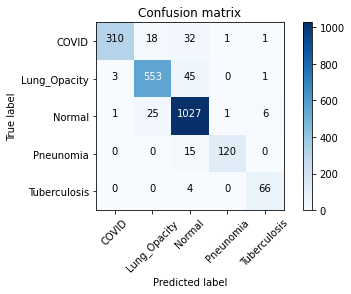

In [14]:
since = time.time()
model.eval()
y_test = []
y_pred = []
y_pred_proba = []
for images, labels in data_loader['test']:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())
    y_pred_proba.append(outputs.data.cpu().numpy())
    
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)
y_pred_proba = np.concatenate(y_pred_proba)
time_elapsed = time.time() - since

print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

confusion_mtx = confusion_matrix(y_test, y_pred)
# plot the confusion matrix
plot_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Pneunomia', 'Tuberculosis']

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_test, y_pred, digits=5)
print(report)

In [15]:
def softmax(vec):
    exponential = np.exp(vec)
    probabilities = exponential / np.sum(exponential)
    return probabilities

y_pred_proba = np.array([list(softmax(i)) for i in y_pred_proba])

ROC curve (area = 0.9938)


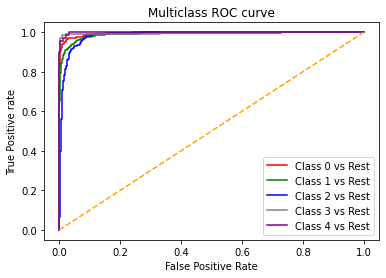

In [16]:
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')
print('ROC curve (area = %0.4f)' % roc_auc)
fpr = {}
tpr = {}
thresh ={}
for i in range(5):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)

# plotting    
plt.plot(fpr[0], tpr[0], color='red', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], color='gray', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], color='purple', label='Class 4 vs Rest')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 